In [14]:
import numpy as np
import matplotlib.pyplot as plt
import fenics as fe

import sys
sys.path.insert(0, "../src")

from swe import ShallowOne
from tqdm import tqdm


fe.set_log_level(50)

In [15]:
swe = ShallowOne(control=dict(nx=1000, dt=1., theta=0.6, simulation="tidal_flow"), 
                 params=dict(nu=1.))

In [20]:
t_final = 60 * 60 * 1.
nt = int(t_final / swe.dt)

t = 0.
for i in tqdm(range(nt)):
    t += swe.dt
    swe.solve(t)

100%|████████████████████████████████████████████████████████████████████| 3600/3600 [00:24<00:00, 145.82it/s]


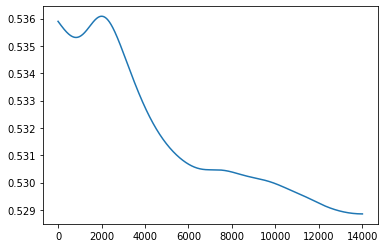

In [21]:
u, h = fe.split(swe.du)
fe.plot(h)
plt.show()